<a target="_blank" href="https://colab.research.google.com/github/sappw1/Dissertation/blob/main/Notebooks/Notebooks-Working/ETL/PPP_Loan_EDA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [12]:
import pandas as pd
import numpy as np

# Load the preprocessed, labeled PPP loan dataset (before scaling)
df = pd.read_csv("Data/Processed/ppp_loans_labeled29apr25.csv")

# Recalculate ForgivenessAmountRatio
if "forgivenessamount" in df.columns and "currentapprovalamount" in df.columns:
    df["forgivenessamountratio"] = df["forgivenessamount"] / df["currentapprovalamount"]
    df["forgivenessamountratio"] = df["forgivenessamountratio"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Create loan_per_job feature
df["loan_per_job"] = df["currentapprovalamount"] / df["jobsreported"].replace(0, np.nan)
df["loan_per_job"] = df["loan_per_job"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Confirm shape and fraud counts
print("✅ Loaded dataset for EDA")
print("Shape:", df.shape)
print(df["is_fraudulent"].value_counts())



✅ Loaded dataset for EDA
Shape: (968525, 58)
is_fraudulent
0    968224
1       301
Name: count, dtype: int64


In [13]:
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Disable column width truncation
pd.set_option('display.max_colwidth', None)

In [14]:
# Summary table split by fraud label
summary = df.groupby("is_fraudulent")[["currentapprovalamount", "jobsreported", "forgivenessamountratio"]].agg(["mean", "std", "median", "min", "max"]).round(2)
summary.columns = ["_".join(col).strip() for col in summary.columns.values]
summary.reset_index(inplace=True)

# Display summary table
display(summary)


,is_fraudulent,currentapprovalamount_mean,currentapprovalamount_std,currentapprovalamount_median,currentapprovalamount_min,currentapprovalamount_max,jobsreported_mean,jobsreported_std,jobsreported_median,jobsreported_min,jobsreported_max,forgivenessamountratio_mean,forgivenessamountratio_std,forgivenessamountratio_median,forgivenessamountratio_min,forgivenessamountratio_max
0,0,530486.47,737515.30,295000.0,150000.0,10000000.0,51.88,67.55,30.0,0.0,500.0,0.97,0.17,1.01,0.0,2.02
1,1,958492.36,1458612.38,420552.0,150000.0,10000000.0,61.79,86.97,26.0,3.0,490.0,0.32,0.47,0.00,0.0,1.03


In [127]:
# Step 1: Create the summary table again (if needed)
summary = df.groupby("is_fraudulent")[[
    "currentapprovalamount",
    "jobsreported",
    "forgivenessamountratio"
]].agg(["mean", "std", "median", "min", "max"]).round(2)

summary.columns = ["_".join(col).strip() for col in summary.columns.values]
summary.reset_index(inplace=True)
summary["is_fraudulent"] = summary["is_fraudulent"].map({0: "Non-Fraud", 1: "Fraud"})

# Step 2: Transpose for export
summary_t = summary.set_index("is_fraudulent").T
summary_t.reset_index(inplace=True)
summary_t.rename(columns={"index": "Metric"}, inplace=True)

# Step 3: Replace technical labels with APA-style labels
label_map = {
    "currentapprovalamount_mean": "Loan Amount (Mean)",
    "currentapprovalamount_std": "Loan Amount (SD)",
    "currentapprovalamount_median": "Loan Amount (Median)",
    "currentapprovalamount_min": "Loan Amount (Min)",
    "currentapprovalamount_max": "Loan Amount (Max)",
    "jobsreported_mean": "Jobs Reported (Mean)",
    "jobsreported_std": "Jobs Reported (SD)",
    "jobsreported_median": "Jobs Reported (Median)",
    "jobsreported_min": "Jobs Reported (Min)",
    "jobsreported_max": "Jobs Reported (Max)",
    "forgivenessamountratio_mean": "Forgiveness Ratio (Mean)",
    "forgivenessamountratio_std": "Forgiveness Ratio (SD)",
    "forgivenessamountratio_median": "Forgiveness Ratio (Median)",
    "forgivenessamountratio_min": "Forgiveness Ratio (Min)",
    "forgivenessamountratio_max": "Forgiveness Ratio (Max)"
}

summary_t["Metric"] = summary_t["Metric"].map(label_map)

# Step 4: Export to LaTeX
summary_t.to_latex(
    "Figures/Working/summary_table.tex",
    index=False,
    caption=None,
    label=None,
    float_format="%.2f",
    column_format="lrr",
    escape=False
)


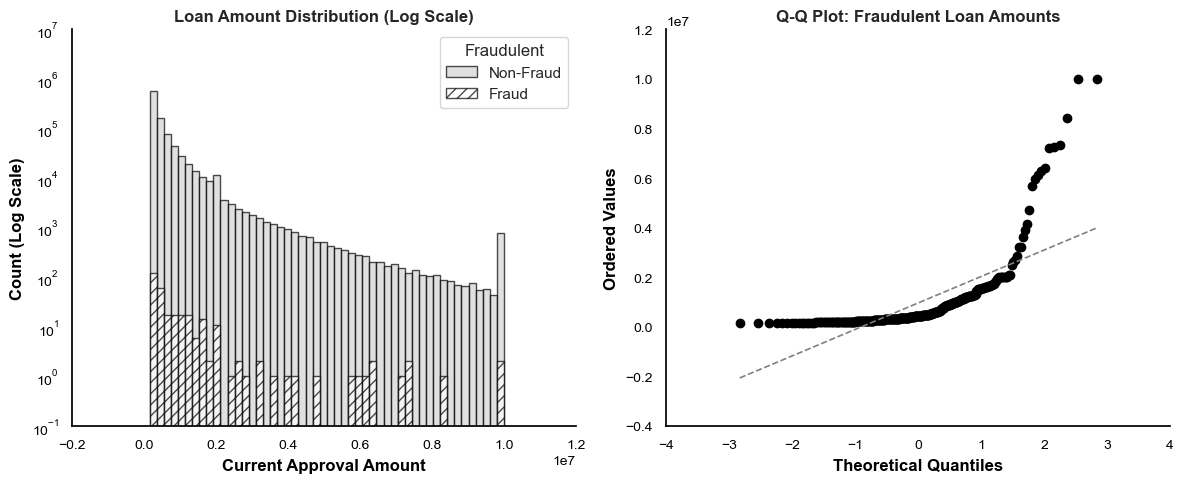

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load APA style
plt.style.use("apa.mplstyle")

# Subset data
fraud = df[df["is_fraudulent"] == 1]["currentapprovalamount"].dropna()
nonfraud = df[df["is_fraudulent"] == 0]["currentapprovalamount"].dropna()

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Histogram (Log Scale, Hatched for Fraud) ---
bins = 50
axes[0].hist(
    nonfraud,
    bins=bins,
    log=True,
    alpha=0.7,
    color="lightgray",
    edgecolor="black",
    label="Non-Fraud"
)
axes[0].hist(
    fraud,
    bins=bins,
    log=True,
    alpha=0.7,
    color="white",
    edgecolor="black",
    hatch="///",
    label="Fraud"
)
axes[0].set_title("Loan Amount Distribution (Log Scale)")
axes[0].set_xlabel("Current Approval Amount")
axes[0].set_ylabel("Count (Log Scale)")
axes[0].legend(title="Fraudulent")

# Generate and plot Q-Q plot on given axes
stats.probplot(fraud, dist="norm", plot=axes[1])

# Fix style manually (applies *after* the auto-plot)
axes[1].lines[0].set_markerfacecolor("black")   # Observed points
axes[1].lines[0].set_markeredgecolor("black")
axes[1].lines[1].set_color("gray")              # Reference line
axes[1].lines[1].set_linestyle("--")

# Set title and labels
axes[1].set_title("Q-Q Plot: Fraudulent Loan Amounts")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Ordered Values")


# Final APA-style layout
sns.despine()
plt.tight_layout()
plt.savefig("Figures/Working/loan_amount_distribution_qq.png", dpi=300, bbox_inches="tight")
plt.show()



Figure 4.X. Distribution of PPP loan approval amounts and Q-Q plot of known fraudulent loans. Left: Histogram shows the distribution of current loan approval amounts on a log scale, with hatched bars representing known fraud cases. Right: Quantile-quantile (Q-Q) plot compares the distribution of fraudulent loan amounts to a theoretical normal distribution. The observed positive skew and heavy upper tail suggest significant deviation from normality among fraudulent loan amounts.

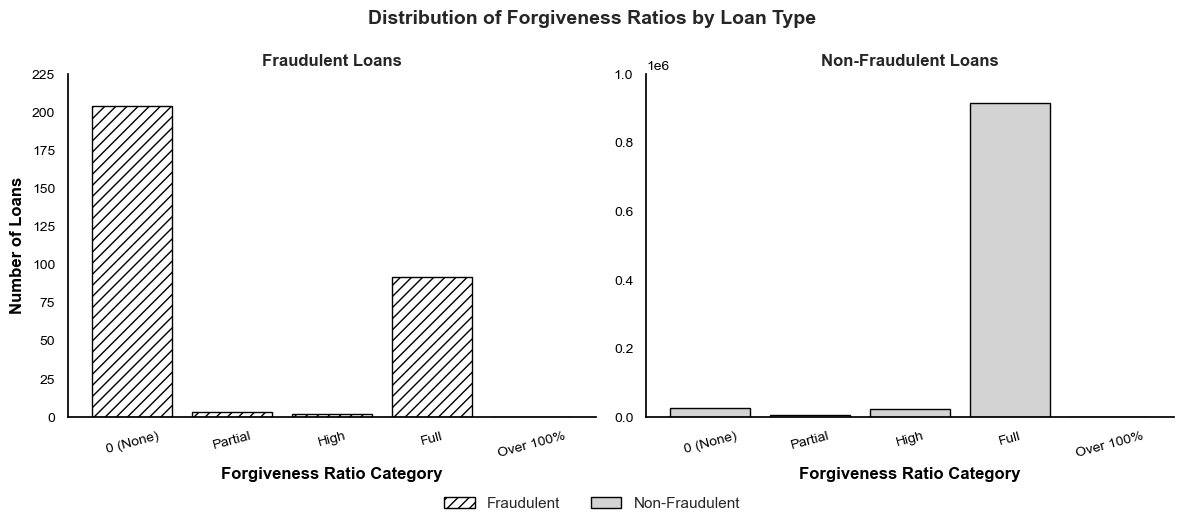

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Define forgiveness ratio bins
bin_edges = [-0.01, 0.01, 0.5, 0.95, 1.05, 2]
bin_labels = ["0 (None)", "Partial", "High", "Full", "Over 100%"]

# Bin both fraud and non-fraud
df["forgiveness_bin"] = pd.cut(
    df["forgivenessamountratio"],
    bins=bin_edges,
    labels=bin_labels
)

# Get counts separately
fraud_counts = df[df["is_fraudulent"] == 1]["forgiveness_bin"].value_counts().reindex(bin_labels, fill_value=0)
nonfraud_counts = df[df["is_fraudulent"] == 0]["forgiveness_bin"].value_counts().reindex(bin_labels, fill_value=0)

# APA style
plt.style.use("apa.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # <-- No sharey

# Fraud subplot
axes[0].bar(
    x=bin_labels,
    height=fraud_counts.values,
    color="white",
    edgecolor="black",
    hatch="///"
)
axes[0].set_title("Fraudulent Loans")
axes[0].set_xlabel("Forgiveness Ratio Category")
axes[0].set_ylabel("Number of Loans")
axes[0].tick_params(axis="x", labelrotation=15)

# Non-fraud subplot
axes[1].bar(
    x=bin_labels,
    height=nonfraud_counts.values,
    color="lightgray",
    edgecolor="black"
)
axes[1].set_title("Non-Fraudulent Loans")
axes[1].set_xlabel("Forgiveness Ratio Category")
axes[1].tick_params(axis="x", labelrotation=15)

# Shared legend and layout
fig.suptitle("Distribution of Forgiveness Ratios by Loan Type", fontsize=14, fontweight="bold")
fig.legend(["Fraudulent", "Non-Fraudulent"], loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()

# Save or show
plt.savefig("Figures/Working/forgiveness_ratio_binned_sidebyside_splity.png", dpi=300, bbox_inches="tight")
plt.show()


Figure 4.X. Distribution of binned forgiveness amount ratios by loan type. Fraudulent loans (left) show a bimodal pattern: most received no forgiveness, while a smaller subset were fully forgiven. In contrast, non-fraudulent loans (right) were overwhelmingly fully forgiven. Note: y-axis scales differ between plots to emphasize relative distributions.

C:\Users\sappw\AppData\Local\Temp\ipykernel_64372\3546357113.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


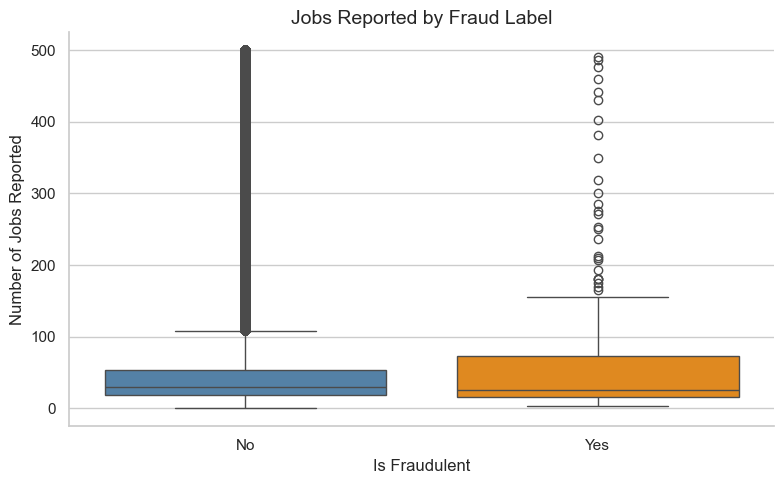

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="is_fraudulent",
    y="jobsreported",
    palette=["steelblue", "darkorange"]
)
plt.title("Jobs Reported by Fraud Label", fontsize=14)
plt.xlabel("Is Fraudulent")
plt.ylabel("Number of Jobs Reported")
plt.xticks([0, 1], ["No", "Yes"])
sns.despine()
plt.tight_layout()
plt.show()



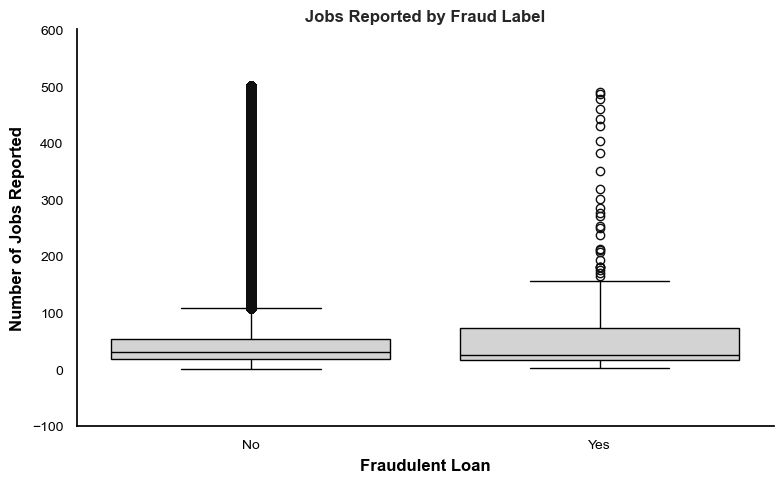

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply APA style
plt.style.use("apa.mplstyle")

# Create figure
plt.figure(figsize=(8, 5))

# Draw boxplot with APA-compliant styling
ax = sns.boxplot(
    data=df,
    x="is_fraudulent",
    y="jobsreported",
    showcaps=True,
    boxprops=dict(facecolor="lightgray", edgecolor="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black")
)

# Attempt hatch on fraud box (optional: export to .pdf for best result)
for i, artist in enumerate(ax.artists):
    if i == 1:
        artist.set_hatch("///")
        artist.set_facecolor("white")
        artist.set_edgecolor("black")

# Set labels and ticks
ax.set_title("Jobs Reported by Fraud Label")
ax.set_xlabel("Fraudulent Loan")
ax.set_ylabel("Number of Jobs Reported")
ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])

sns.despine()
plt.tight_layout()

# Save or show
plt.savefig("Figures/Working/jobs_reported_boxplot_linear.png", dpi=300, bbox_inches="tight")
plt.show()


Figure 4.X. Boxplot of reported jobs by fraud classification. The non-fraudulent group includes a greater number of extreme outliers in job counts, compressing the IQR and median ranges visually. The central tendency between groups appears similar on a linear scale, though distributional variation is less discernible without transformation.

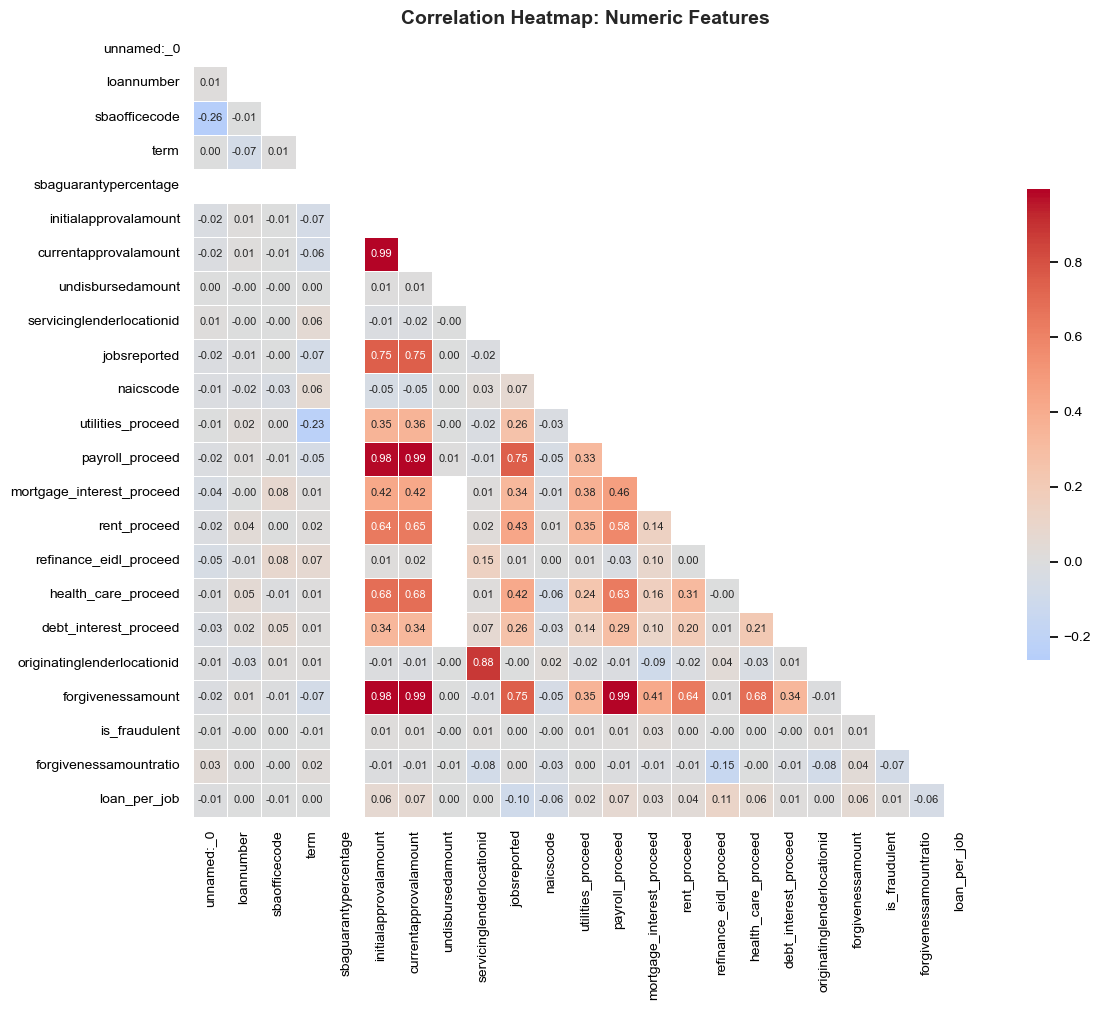

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# APA style
plt.style.use("apa.mplstyle")

# Correlation matrix
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},  # reduced annotation font size
    cmap="coolwarm",
    center=0,
    mask=mask,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.6}
)

plt.title("Correlation Heatmap: Numeric Features", fontsize=14)
plt.tight_layout()

# Save or display
plt.savefig("Figures/Working/correlation_heatmap_lower_triangle_smallfont.png", dpi=300, bbox_inches="tight")
plt.show()


Figure 4.X. Lower-triangle Pearson correlation heatmap of numeric variables in the PPP dataset. Strong associations are observed among loan approval amounts and related financial disbursements. The binary fraud indicator exhibits low individual correlations with most features, supporting the need for multivariate or semi-supervised modeling approaches.

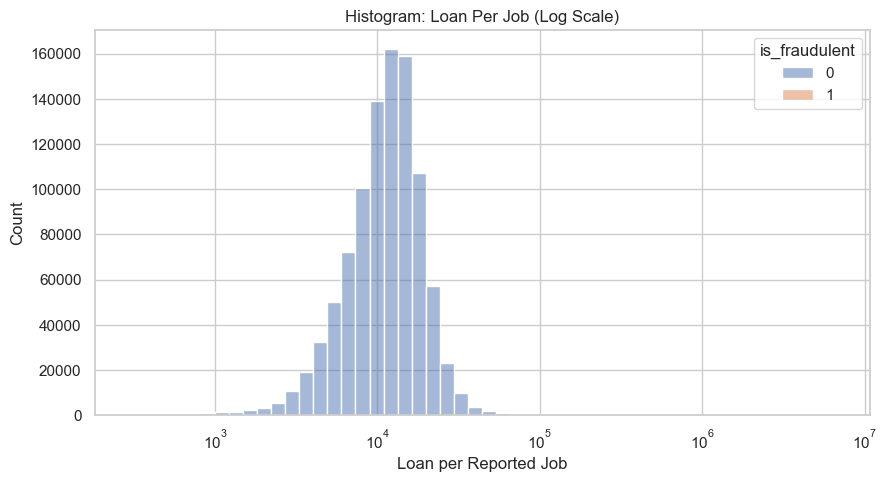

In [19]:
# Add a derived feature: loan amount per employee
df["loan_per_job"] = df["currentapprovalamount"] / df["jobsreported"].replace(0, np.nan)
df["loan_per_job"] = df["loan_per_job"].replace([np.inf, -np.inf], np.nan)

# Histogram of loan_per_job
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="loan_per_job", hue="is_fraudulent", bins=50, log_scale=True)
plt.title("Histogram: Loan Per Job (Log Scale)")
plt.xlabel("Loan per Reported Job")
plt.show()


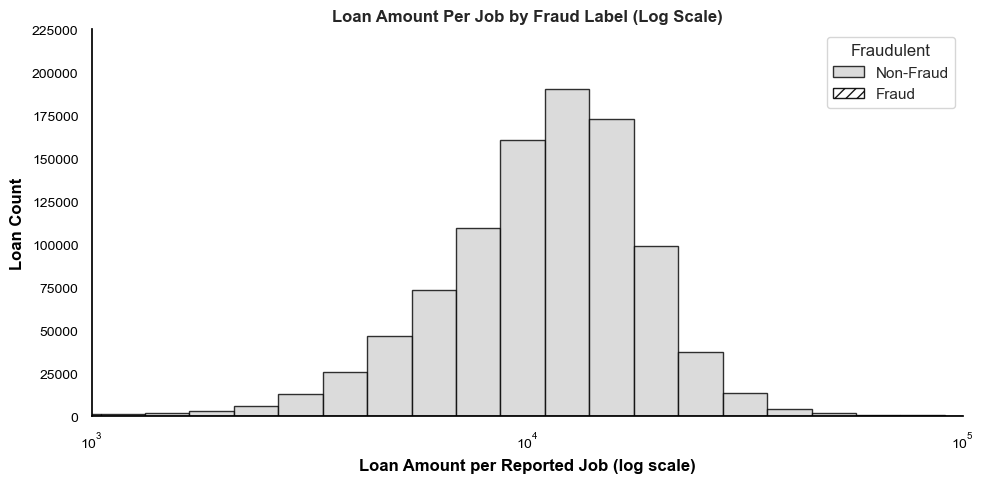

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# APA style
plt.style.use("apa.mplstyle")

# Clean the data
df["loan_per_job"] = df["currentapprovalamount"] / df["jobsreported"].replace(0, np.nan)
df["loan_per_job"] = df["loan_per_job"].replace([np.inf, -np.inf], np.nan)

# Split fraud and non-fraud
nonfraud = df[df["is_fraudulent"] == 0]["loan_per_job"].dropna()
fraud = df[df["is_fraudulent"] == 1]["loan_per_job"].dropna()

# Plot
plt.figure(figsize=(10, 5))
bins = np.logspace(np.log10(100), np.log10(1e7), 50)

# Non-fraud bars
plt.hist(
    nonfraud,
    bins=bins,
    color="lightgray",
    edgecolor="black",
    label="Non-Fraud",
    alpha=0.8
)

# Fraud bars (hatched)
plt.hist(
    fraud,
    bins=bins,
    color="white",
    edgecolor="black",
    hatch="///",
    label="Fraud",
    alpha=0.9
)

# Axis formatting
plt.xscale("log")
plt.xlim(1e3, 1e5)  # ← LIMIT X-AXIS RANGE TO REDUCE WHITE SPACE
plt.xlabel("Loan Amount per Reported Job (log scale)")
plt.ylabel("Loan Count")
plt.title("Loan Amount Per Job by Fraud Label (Log Scale)")
plt.legend(title="Fraudulent")
sns.despine()
plt.tight_layout()

# Save or show
plt.savefig("Figures/Working/loan_per_job_histogram_hatched.png", dpi=300, bbox_inches="tight")
plt.show()


Figure 4.X. Histogram of loan amount per reported job on a logarithmic scale. Fraudulent loans (hatched) are disproportionately represented at higher loan-per-job ratios, suggesting potential inflation of loan amounts or underreporting of employment. The x-axis is restricted to the range containing nearly all observations.